<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
!unzip mltle.zip
!pip install scikit-plot
!pip install lifelines
!pip install tensorflow-addons
!pip install rdkit-pypi # rdkit is not strongly necessary

In [1]:
import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa

In [2]:
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm

from collections import defaultdict

import pandas as pd
import numpy as np
from keras import backend as K

import tensorflow as tf

tqdm.pandas()

In [3]:
import mltle as mlt

Failed to load RDkit. `mltle.utils` is not available
Done.


In [4]:
SEED = 7

NUM_RES_BLOCKS = 2
NUM_EPOCHS = 20
DISCOUNT = 0.9
BATCH_SIZE = 128

In [5]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.training.Model(drug_emb_size=128,
              protein_emb_size=64,
              max_drug_len=200,
              drug_alphabet_len=53,
              protein_alphabet_len=8006)

order = ['p1Ki', 'p1IC50', 'p1Kd', 'p1EC50', 'is_active', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training.LossWithMemoryCallback(variables, discount=DISCOUNT, decay = 0.8)

uselosses = defaultdict(lambda: mlt.training.mse_loss_wrapper)
uselosses['is_active'] = 'binary_crossentropy'
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {'is_active': tf.keras.metrics.AUC()}

activations = defaultdict(lambda: 'linear')
activations['is_active'] = 'sigmoid'
activations[ 'qed']  = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                            activations=activations,
                            activation = 'relu',
                            pooling_mode = 'max',
                            num_res_blocks=NUM_RES_BLOCKS,
                            units_per_head=64,
                            units_per_layer=1024,
                            dropout_rate=0.3,
                            drug_kernel=(2, 3),
                            protein_kernel=(7, 7),
                            loss_weights=loss_weights,
                            usemetrics=usemetrics,
                            uselosses=uselosses,
                            initializer=initializer,
                            optimizer=optimizer,
                            drug_strides_up=1,
                            protein_strides_down=1,
                            positional=False)

Done. Total params: 2429831


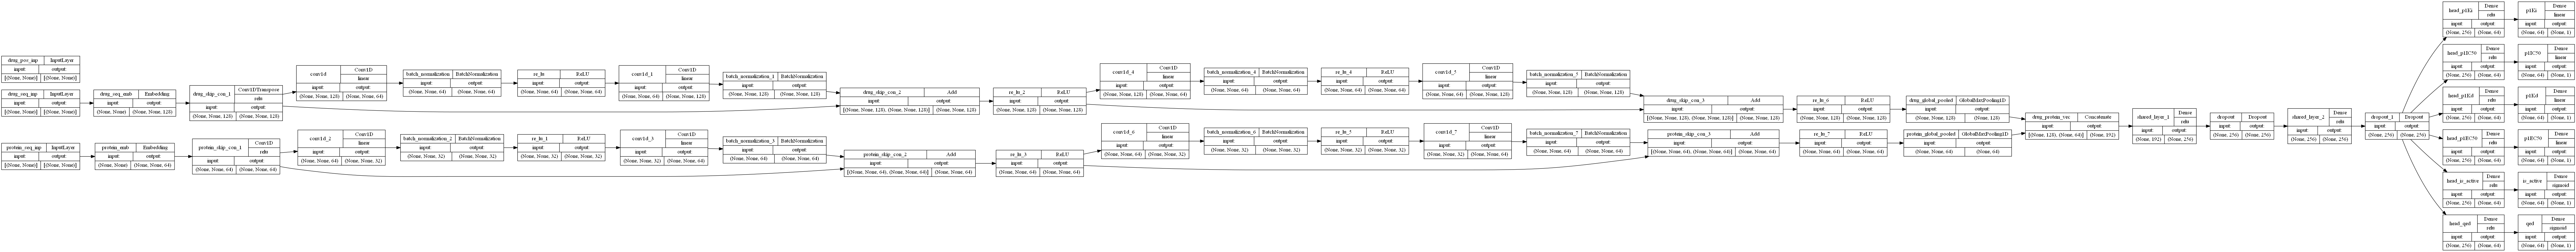

In [7]:
tf.keras.utils.plot_model(model,
                          rankdir='LR',
                          show_shapes=True,
                          show_layer_activations=True,
                          dpi=96)

In [6]:
data = pd.read_csv("data_human_agg044.zip", compression='zip')
data = data[['smiles', 'target'] + order]
data = data.sample(frac=1, random_state = 7)

In [7]:
scalers = {}

for col in order:
    if col not in  ['is_active', 'qed']:
        scalers[col] = (data[col].mean(), data[col].std())
        data[col] = (data[col] - scalers[col][0]) / scalers[col][1]

In [8]:
scalers

{'p1Ki': (4.68724712073933, 3.150376081442799),
 'p1IC50': (5.596417394599766, 3.0825703732273695),
 'p1Kd': (5.708832317036149, 3.1862159752473724),
 'p1EC50': (5.5931368472782825, 3.019050509072832),
 'pH': (7.228441335293337, 0.7662322258086897)}

In [9]:
mapseq = mlt.datamap.MapSeq(drug_mode='smiles_1',
                                                    protein_mode='protein_3',
                                                    max_drug_len=200,
                                                    max_protein_len=1000)

drug_seqs, protein_seqs = data['smiles'].unique(), data['target'].unique()

map_drug, map_protein = mapseq.create_maps(drug_seqs = drug_seqs, protein_seqs = protein_seqs)

  0%|          | 0/497854 [00:00<?, ?it/s]

  0%|          | 0/1832 [00:00<?, ?it/s]

In [10]:
X_train, X_test = train_test_split(data,
                                   test_size=0.1,
                                   shuffle=True,
                                   random_state=7,
                                   stratify=data['is_active'])

X_train, X_valid = train_test_split(X_train,
                                    test_size=0.1,
                                    shuffle=True,
                                    random_state=7,
                                    stratify=X_train['is_active'])

X_train.shape[0], X_test.shape[0], X_valid.shape[0]

(580236, 71635, 64471)

In [11]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(X_train, map_drug, map_protein)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(X_valid, map_drug, map_protein)
valid_gen = valid_gen.get_generator(batch_size)

In [12]:
steps_per_epoch = X_train.shape[0] // batch_size
valid_steps = X_valid.shape[0] // batch_size

In [13]:
filepath = "Res2_09_qed_ph_{epoch:02d}-{val_is_active_auc:.5f}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='val_is_active_auc',
                                                verbose=1,
                                                save_best_only=False,
                                                mode='auto',
                                                save_weights_only=True)


CSVLoggerCallback = tf.keras.callbacks.CSVLogger("Res2_09_qed_ph.log")

In [14]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback, LossCallback, CSVLoggerCallback],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: saving model to Res2_09_qed_ph_01-0.81772.h5

Epoch 2: saving model to Res2_09_qed_ph_02-0.83841.h5

Epoch 3: saving model to Res2_09_qed_ph_03-0.84728.h5

Epoch 4: saving model to Res2_09_qed_ph_04-0.86085.h5

Epoch 5: saving model to Res2_09_qed_ph_05-0.86621.h5

Epoch 6: saving model to Res2_09_qed_ph_06-0.87427.h5

Epoch 7: saving model to Res2_09_qed_ph_07-0.87754.h5

Epoch 8: saving model to Res2_09_qed_ph_08-0.88169.h5

Epoch 9: saving model to Res2_09_qed_ph_09-0.88420.h5

Epoch 10: saving model to Res2_09_qed_ph_10-0.88673.h5

Epoch 11: saving model to Res2_09_qed_ph_11-0.88971.h5

Epoch 12: saving model to Res2_09_qed_ph_12-0.89176.h5

Epoch 13: saving model to Res2_09_qed_ph_13-0.89270.h5

Epoch 14: saving model to Res2_09_qed_ph_14-0.89629.h5

Epoch 15: saving model to Res2_09_qed_ph_15-0.89811.h5

Epoch 16: saving model to Res2_09_qed_ph_16-0.89918.h5

Epoch 17: saving model to Res2_09_qed_ph_17-0.90010.h5

Epoch 18: saving model to Res2_09_qed_ph_18-0.90057.h5



In [15]:
[f"{k} : {float(v)}" for k, v in variables.items()]

['p1Ki : 0.0041870358400046825',
 'p1IC50 : 0.006293777842074633',
 'p1Kd : 0.001371088670566678',
 'p1EC50 : 0.002299085957929492',
 'is_active : 0.007631550543010235',
 'qed : 0.01021682471036911',
 'pH : 0.0013696231180801988']

In [16]:
model.load_weights('Res2_09_qed_ph_20-0.90284.h5')
model.compile()
model.save("Res2_09_qed_ph.hdf5")

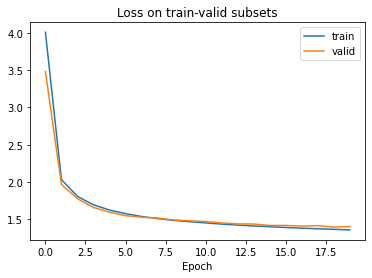

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.title('Loss on train-valid subsets')
plt.legend()

In [18]:
def get_batch_size(S):
    mbs = 1
    for i in range(1, min(128, S)):
        if S % i == 0:
            mbs = i
    assert S % mbs == 0

    return mbs

In [19]:
test_batch_size = get_batch_size(X_test.shape[0])
test_batch_size 

5

In [20]:
test_gen = mlt.datagen.DataGen(X_test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True)

test_gen = test_gen.get_generator(test_batch_size)

In [21]:
prediction = model.predict(test_gen, steps=X_test.shape[0] // test_batch_size , verbose=1)

14327/14327 [==============================] - 125s 9ms/step


In [22]:
def get_scores(y_true, y_pred):
    mse = np.round(mean_squared_error(y_true, y_pred), 3)
    rmse = np.round(mse**0.5, 3)
    ci = np.round(concordance_index(y_true, y_pred), 3)
    pearson = np.round(stats.pearsonr(y_true, y_pred)[0], 3)
    spearman = np.round(stats.spearmanr(y_true, y_pred)[0], 3)

    res = f"rmse={rmse}, mse={mse},\npearson={pearson}, spearman={spearman},\nci={ci}"

    return res

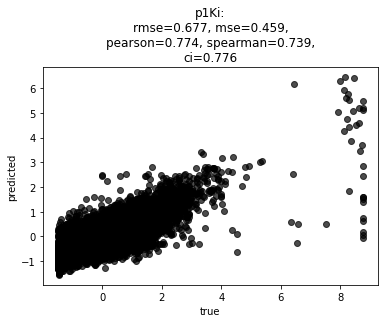

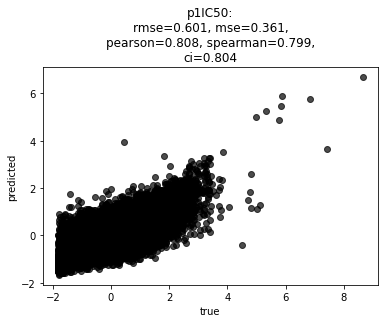

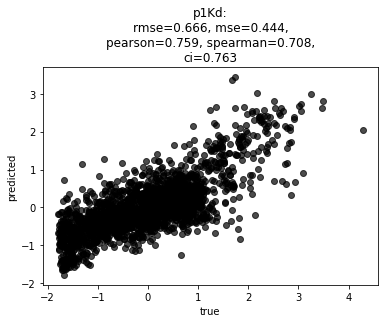

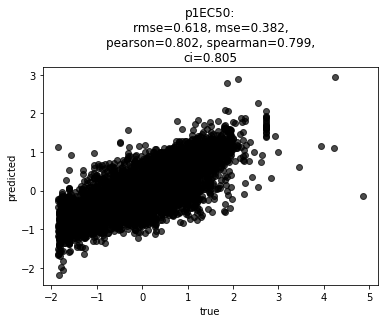

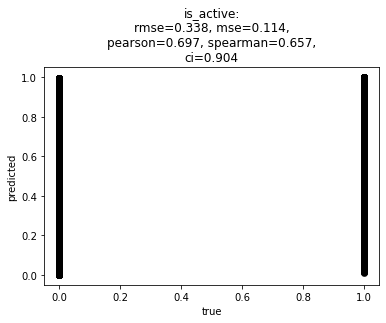

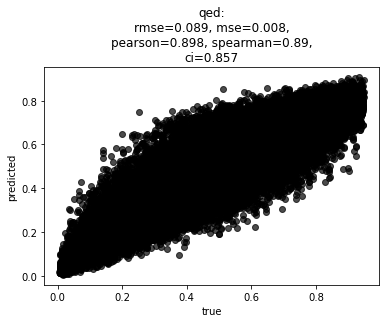

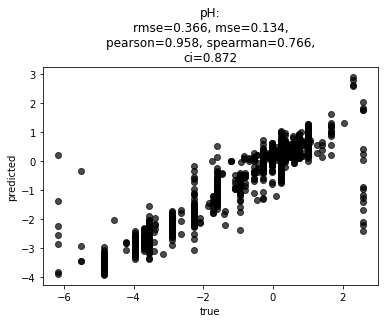

In [23]:
for k, col in enumerate(order):
    plt.scatter(X_test[col], prediction[k], alpha=0.7, c='k')
    plt.xlabel('true')
    plt.ylabel('predicted')
    y_true = X_test[col][X_test[col].notna()]
    y_pred = prediction[k][X_test[col].notna()].ravel()
    plt.title(col + ":\n" + get_scores(y_true, y_pred))
    plt.show()

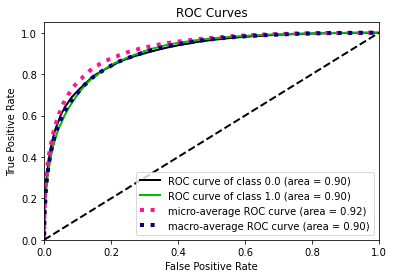

In [24]:
p = prediction[order.index('is_active')].ravel().tolist()
probas = np.zeros((len(p), 2))
probas[:, 1] = p
probas[:, 0] = 1
probas[:, 0] = probas[:, 0] - p
skplt.metrics.plot_roc(X_test['is_active'].values.ravel().tolist(), probas)
plt.show()

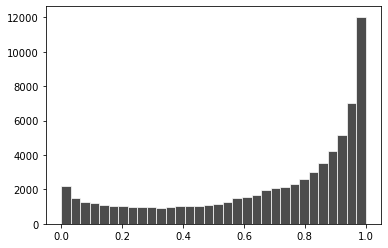

In [25]:
h = plt.hist(prediction[order.index('is_active')].ravel(),
             bins=32,
             edgecolor='w',
             color='k',
             alpha=0.7)